https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied/version/1?select=Should+This+Loan+be+Approved+or+Denied+A+Large+Dataset+with+Class+Assignment+Guidelines.pdf

https://www.kaggle.com/kevinm6720/sba-loan-approval-analysis

## Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3

# time
import datetime as dt
from datetime import datetime

#plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data prep

In [2]:
# function for plotting histogram.
def histogram_plot(df, col_name):
    plt.figure(figsize=(10,6))
    sns.countplot(x=df[col_name])
    plt.xticks(rotation=60)
    plt.show()

# function for plotting lines.
def line_plot(df, col_name): 
    plt.figure(figsize=(10,6))
    plt.plot(df[col_name])
    plt.xticks(rotation=90)
    plt.show()    

# function for plotting barplot.
def ordered_barplot(df, col_name): 
    data = df.groupby([col_name]).size().reset_index(name='counts').sort_values(by = 'counts', ascending=False)
    labels = data[col_name]
    count = data.counts
    plt.bar(labels, count)
    plt.xticks(rotation=90)
    plt.show()    

In [3]:
# load data
df = pd.read_csv(r"Data\SBAnational.csv", sep = ',', low_memory=False)

### 1.1. Missing data

In [4]:
# number of missings
df.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [5]:
# Drop null values from specified columns
df.dropna(subset=['Name', 'City', 'State', 'BankState', 'NewExist','RevLineCr', 'LowDoc', 'DisbursementDate', 'MIS_Status'], inplace=True)
df.isnull().sum()

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr                 0
LowDoc                    0
ChgOffDate           725369
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

### 1.2. Correct data types

In [6]:
# Check data types of each feature
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

In [7]:
# Remove '$', commas, and extra spaces from records in columns with dollar values that should be floats
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

# Correct ApprovalFY variable
def clean_str(x):
    if isinstance(x, str):
        return x.replace('A', '')
    return x
df['ApprovalFY'] = df['ApprovalFY'].apply(clean_str).astype('int64')

# Change the type of NewExist to an integer, Zip and UrbanRural to str (categorical) and all currency-related fields to float values
df = df.astype({'Zip': 'str', 
                'NewExist': 'int64', 
                'UrbanRural': 'str', 
                'DisbursementGross': 'float', 
                'BalanceGross': 'float',
                'ChgOffPrinGr': 'float', 
                'GrAppv': 'float', 
                'SBA_Appv': 'float'})

In [8]:
# Check to see dtypes so far
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                   object
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist               int64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural            object
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross    float64
BalanceGross         float64
MIS_Status            object
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
dtype: object

### 1.3. Industry correction

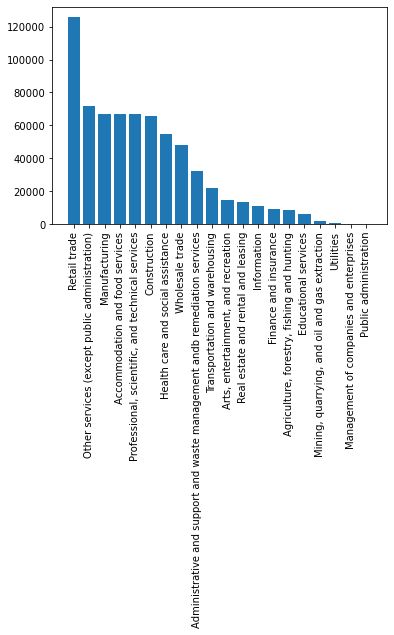

In [9]:
# Selects only the first two numbers of the NAICS code
df['industry_id'] = df['NAICS'].astype('str').apply(lambda x: x[:2]).astype('int')

# Maps the approprate industry to each record based on the first two digits of the NAICS code
df['industry_label'] = df['industry_id'].map({11: 'Agriculture, forestry, fishing and hunting',
                                              21: 'Mining, quarrying, and oil and gas extraction',
                                              22: 'Utilities',
                                              23: 'Construction',
                                              31: 'Manufacturing',
                                              32: 'Manufacturing',
                                              33: 'Manufacturing',
                                              42: 'Wholesale trade',
                                              44: 'Retail trade',
                                              45: 'Retail trade',
                                              48: 'Transportation and warehousing',
                                              49: 'Transportation and warehousing',
                                              51: 'Information',
                                              52: 'Finance and insurance',
                                              53: 'Real estate and rental and leasing',
                                              54: 'Professional, scientific, and technical services',
                                              55: 'Management of companies and enterprises',
                                              56: 'Administrative and support and waste management andb remediation services',
                                              61: 'Educational services',
                                              62: 'Health care and social assistance',
                                              71: 'Arts, entertainment, and recreation',
                                              72: 'Accommodation and food services',
                                              81: 'Other services (except public administration)',
                                              92: 'Public administration'})

# Remove records where Industry is NaN (NAICS code was a 0)
df.dropna(subset=['industry_label'], inplace=True)

# Plot
ordered_barplot(df, col_name='industry_label')

### 1.4. Franchise

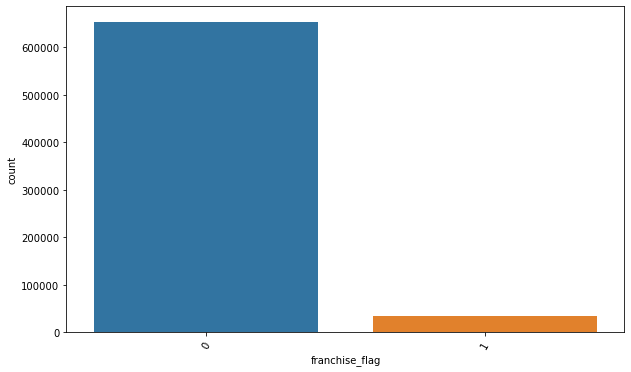

In [10]:
# Create flag column IsFranchise based on FranchiseCode column
df.loc[(df['FranchiseCode'] <= 1), 'franchise_flag'] = 0
df.loc[(df['FranchiseCode'] > 1), 'franchise_flag'] = 1
df['franchise_flag'] = df['franchise_flag'].astype('int64')

# Plot
histogram_plot(df, col_name='franchise_flag')

### 1.5. Business type

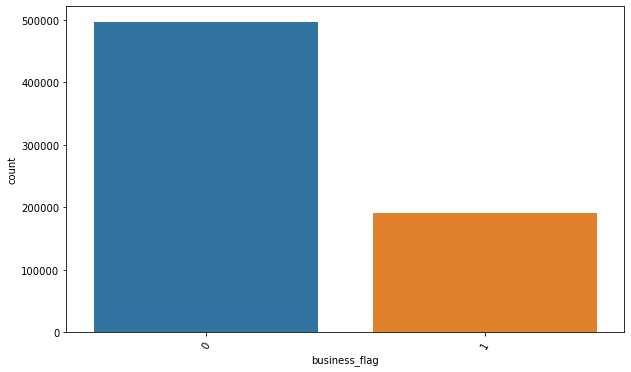

In [11]:
# Keep records where NewExist == 1 or 2
df = df.loc[(df['NewExist'] == 1) | (df['NewExist'] == 2)]

# Create NewBusiness field where 0 = Existing business and 1 = New business; based on NewExist field
df.loc[(df['NewExist'] == 1), 'business_flag'] = 0
df.loc[(df['NewExist'] == 2), 'business_flag'] = 1
df['business_flag'] = df['business_flag'].astype('int64')

# plot
histogram_plot(df, col_name='business_flag')

### 1.6. Revolting line of credit

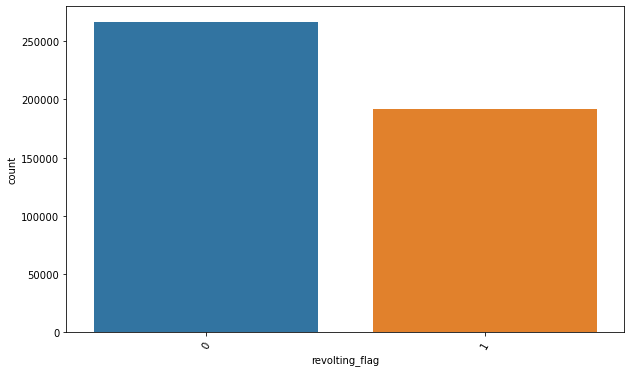

In [12]:
# Remove records where RevLineCr != 'Y' or 'N'
df = df[(df['RevLineCr'] == 'Y') | (df['RevLineCr'] == 'N')]

# RevLineCr_id: 0 = No, 1 = Yes
df['revolting_flag'] = np.where(df['RevLineCr'] == 'N', 0, 1)

# plot
histogram_plot(df, col_name='revolting_flag')

### 1.7. Loan process

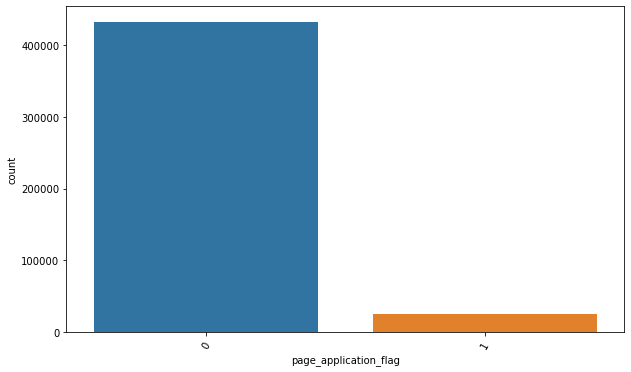

In [13]:
# Remove records where LowDoc != 'Y' or 'N'
df = df[(df['LowDoc'] == 'Y') | (df['LowDoc'] == 'N')]

# LowDoc: 0 = No, 1 = Yes
df['page_application_flag'] = np.where(df['LowDoc'] == 'N', 0, 1)

# plot
histogram_plot(df, col_name='page_application_flag')

### 1.8. Default

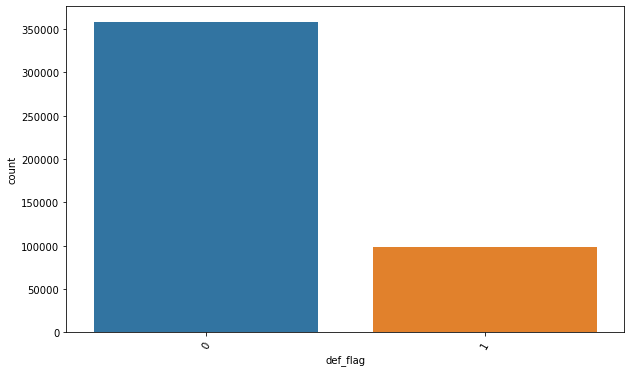

In [14]:
# Make Default target field based on MIS_Status where P I F = 0 and CHGOFF = 1 so we can see what features are prevalant in a defaulted loan
df['def_flag'] = np.where(df['MIS_Status'] == 'P I F', 0, 1)
df['def_flag'].value_counts()

# plot
histogram_plot(df, col_name='def_flag')

### 1.9. Approval and disbursement dates

In [15]:
# Convert ApprovalDate and DisbursementDate columns to datetime values
df[['ApprovalDate', 'DisbursementDate']] = df[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

# Create DaysToDisbursement column which calculates the number of days passed between DisbursementDate and ApprovalDate
df['days_to_disbursement'] = df['DisbursementDate'] - df['ApprovalDate']
df['days_to_disbursement'] = df['days_to_disbursement'].astype('str').apply(lambda x: x[:x.index('d') - 1]).astype('int64')

# Create DisbursementFY field for time selection criteria later
df['disbursement_year'] = df['DisbursementDate'].map(lambda x: x.year)

### 1.10. Geography

In [16]:
# Create StateSame flag field which identifies where the business State is the same as the BankState
df['same_state_flag'] = np.where(df['State'] == df['BankState'], 1, 0)

# Adding address 
df['address'] = df['Zip'].astype(str) + ', ' + df['City'].astype(str)  + ', ' + df['State'].astype(str) + ', USA' 

### 1.11. Guaranteed loan

In [17]:
# Create SBA_AppvPct field since the guaranteed amount is based on a percentage of the gross loan amount rather than dollar amount in most situations
df['guaranteed_pct'] = df['SBA_Appv'] / df['GrAppv']

### 1.12. Bank info encoding

In [18]:
# Encoding banks
df['bank_id'] = df['Bank'].astype('category').cat.codes

### 1.13. Real estate

In [19]:
# Field for loans backed by Real Estate (loans with a term of at least 20 years)
df['real_estate_flag'] = np.where(df['Term'] >= 240, 1, 0)

### 1.14. Activity period

In [20]:
# Field for loans active during the Great Recession (2007-2009)
df['recession_flag'] = np.where(((2007 <= df['disbursement_year']) & (df['disbursement_year'] <= 2009)) |
                                ((df['disbursement_year'] < 2007) & (df['disbursement_year'] + (df['Term']/12) >= 2007)), 1, 0)

### 1.15. Final touches

In [21]:
# drop columns
df.drop(columns=['LoanNr_ChkDgt', 
                 'Name',
                 'BankState',
                 'NAICS', 
                 'ApprovalDate',
                 'DisbursementDate',
                 'NewExist', 
                 'FranchiseCode',
                 'RevLineCr',
                 'LowDoc',
                 'ChgOffDate',
                 'MIS_Status',
                 'BalanceGross'], inplace=True)

In [22]:
# rename the rest
df = df.rename(columns = {'City':'city',
                          'State':'state',
                          'Zip':'zip',
                          'Bank':'bank_label',
                          'ApprovalFY':'approval_year',
                          'Term':'loan_term',
                          'NoEmp':'employee_num',
                          'CreateJob':'jobs_created_num',
                          'RetainedJob':'jobs_retained_num',
                          'UrbanRural':'urban_id',
                          'DisbursementGross':'disbursed_amt',
                          'ChgOffPrinGr':'charged_off_amt',
                          'GrAppv':'approved_amt',
                          'SBA_Appv':'guaranteed_amt'}, inplace = False)

In [23]:
df = df.reindex(sorted(df.columns), axis=1)

In [24]:
# Verify all null values are removed from data
df.isnull().sum()

address                  0
approval_year            0
approved_amt             0
bank_id                  0
bank_label               0
business_flag            0
charged_off_amt          0
city                     0
days_to_disbursement     0
def_flag                 0
disbursed_amt            0
disbursement_year        0
employee_num             0
franchise_flag           0
guaranteed_amt           0
guaranteed_pct           0
industry_id              0
industry_label           0
jobs_created_num         0
jobs_retained_num        0
loan_term                0
page_application_flag    0
real_estate_flag         0
recession_flag           0
revolting_flag           0
same_state_flag          0
state                    0
urban_id                 0
zip                      0
dtype: int64

### 1.16. Save output

In [25]:
# Connect to database
conn=sqlite3.connect(r'Data\loans_database.db')

# Output
df.to_sql("loans", conn, if_exists='replace', index=False)

## 2. Data analysis

### 2.1. Data description

In [26]:
df.describe(include=['object', 'float', 'int'])

,address,approved_amt,bank_label,charged_off_amt,city,def_flag,disbursed_amt,guaranteed_amt,guaranteed_pct,industry_id,industry_label,page_application_flag,real_estate_flag,recession_flag,revolting_flag,same_state_flag,state,urban_id,zip
count,456940,4.569400e+05,456940,4.569400e+05,456940,456940.000000,4.569400e+05,4.569400e+05,456940.000000,456940.000000,456940,456940.000000,456940.000000,456940.000000,456940.000000,456940.000000,456940,456940,456940
unique,58078,NaN,4832,NaN,25166,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,51,3,26898
top,"10001, NEW YORK, NY, USA",NaN,BANK OF AMERICA NATL ASSOC,NaN,LOS ANGELES,NaN,NaN,NaN,NaN,NaN,Retail trade,NaN,NaN,NaN,NaN,NaN,CA,1,10001
freq,583,NaN,60118,NaN,5830,NaN,NaN,NaN,NaN,NaN,80952,NaN,NaN,NaN,NaN,NaN,61387,285558,620
mean,NaN,1.542110e+05,NaN,1.293337e+04,NaN,0.215306,1.721617e+05,1.172058e+05,0.652474,49.859126,NaN,0.054937,0.110327,0.704322,0.420053,0.456872,NaN,NaN,NaN
std,NaN,2.613271e+05,NaN,5.807917e+04,NaN,0.411035,2.751156e+05,2.141966e+05,0.179334,17.453089,NaN,0.227858,0.313298,0.456347,0.493568,0.498137,NaN,NaN,NaN
min,NaN,1.000000e+03,NaN,0.000000e+00,NaN,0.000000,4.000000e+03,5.000000e+02,0.050000,11.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,2.500000e+04,NaN,0.000000e+00,NaN,0.000000,3.500000e+04,1.275000e+04,0.500000,42.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,5.000000e+04,NaN,0.000000e+00,NaN,0.000000,7.576350e+04,3.500000e+04,0.500000,48.000000,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN
75%,NaN,1.570000e+05,NaN,0.000000e+00,NaN,0.000000,1.920000e+05,1.250000e+05,0.819209,62.000000,NaN,0.000000,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN


### 2.2. Correlation matrix

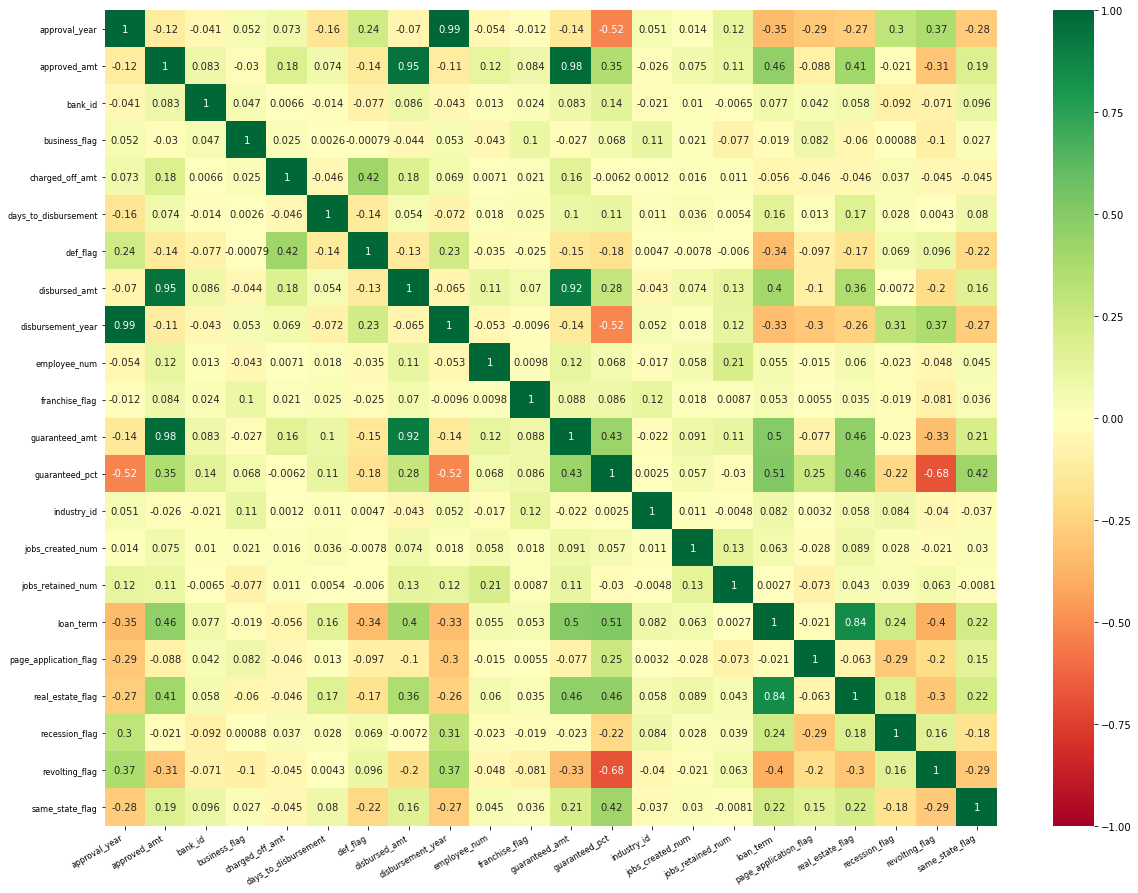

In [27]:
cor_fig, cor_ax = plt.subplots(figsize=(20, 15))
corr_matrix = df.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap="RdYlGn")
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

### 2.3. Total/Average disbursed loan amount by industry

<ipython-input-28-7bb8b6149dd4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_industrySum.index, rotation=30, horizontalalignment='right', fontsize=10)
<ipython-input-28-7bb8b6149dd4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(df_industryAve.index, rotation=30, horizontalalignment='right', fontsize=10)


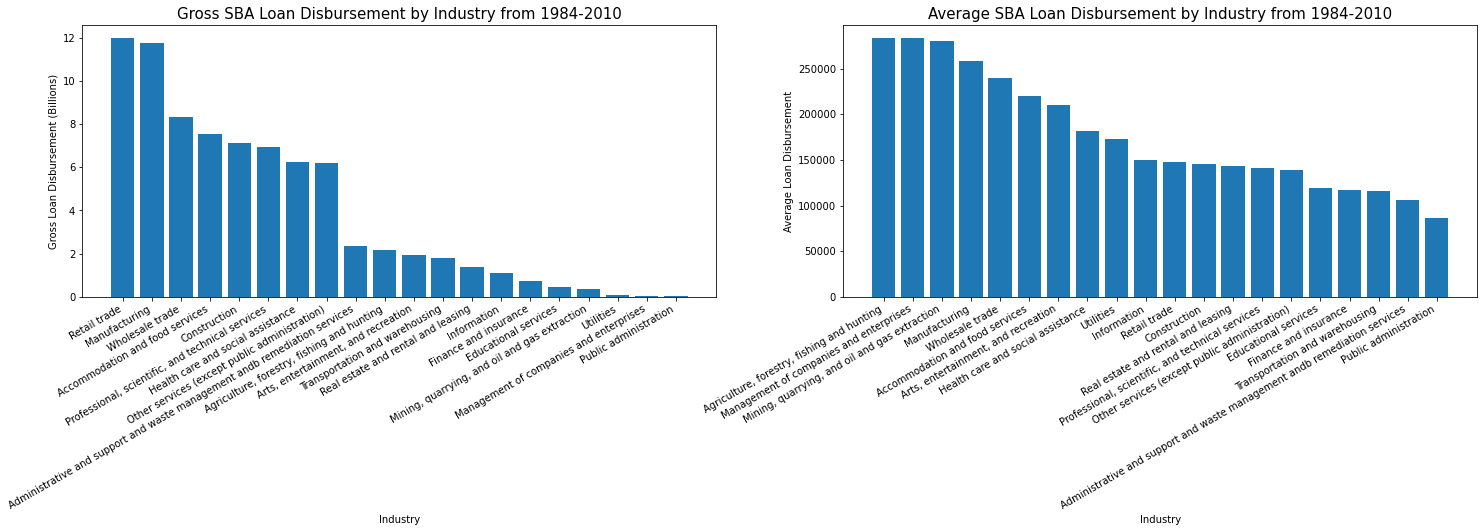

In [28]:
# Create a groupby object on Industry for use in visualization
industry_group = df.groupby(['industry_label'])

# Data frames based on groupby by Industry looking at aggregate and average values
df_industrySum = industry_group.sum().sort_values('disbursed_amt', ascending=False)
df_industryAve = industry_group.mean().sort_values('disbursed_amt', ascending=False)

# Establish figure for placing bar charts side-by-side
fig = plt.figure(figsize=(25, 5))

# Add subplots to figure to build 1x2 grid and specify position of each subplot
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Bar chart 1 = Gross SBA Loan Disbursement by Industry
ax1.bar(df_industrySum.index, df_industrySum['disbursed_amt'] / 1000000000)
ax1.set_xticklabels(df_industrySum.index, rotation=30, horizontalalignment='right', fontsize=10)

ax1.set_title('Gross SBA Loan Disbursement by Industry from 1984-2010', fontsize=15)
ax1.set_xlabel('Industry')
ax1.set_ylabel('Gross Loan Disbursement (Billions)')

# Bar chart 2 = Average SBA Loan Disbursement by Industry
ax2.bar(df_industryAve.index, df_industryAve['disbursed_amt'])
ax2.set_xticklabels(df_industryAve.index, rotation=30, horizontalalignment='right', fontsize=10)

ax2.set_title('Average SBA Loan Disbursement by Industry from 1984-2010', fontsize=15)
ax2.set_xlabel('Industry')
ax2.set_ylabel('Average Loan Disbursement')

plt.show()

### 2.4. Average days to disbursement by industry

<ipython-input-29-ba2b7664ebcf>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_industryAve['days_to_disbursement'].sort_values(ascending=False).index, rotation=35,


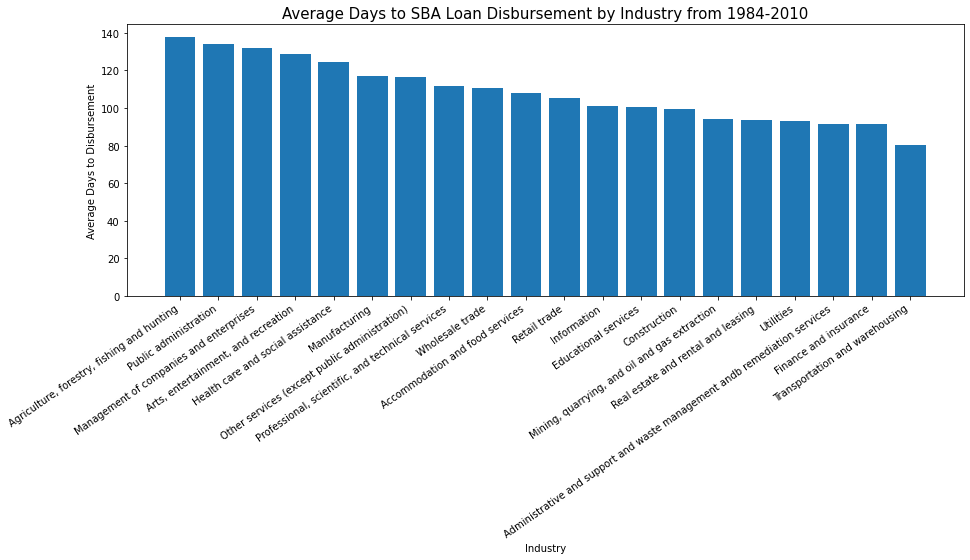

In [29]:
fig2, ax = plt.subplots(figsize=(15, 5))

ax.bar(df_industryAve.index, df_industryAve['days_to_disbursement'].sort_values(ascending=False))
ax.set_xticklabels(df_industryAve['days_to_disbursement'].sort_values(ascending=False).index, rotation=35,
                   horizontalalignment='right', fontsize=10)

ax.set_title('Average Days to SBA Loan Disbursement by Industry from 1984-2010', fontsize=15)
ax.set_xlabel('Industry')
ax.set_ylabel('Average Days to Disbursement')

plt.show()

### 2.5. Paid in full and defaulted loans

<ipython-input-37-fc2fb5ff2c8c>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1a.set_xticklabels(df.groupby(['industry_label', 'def_flag'])['industry_label'].count().unstack('def_flag').index,


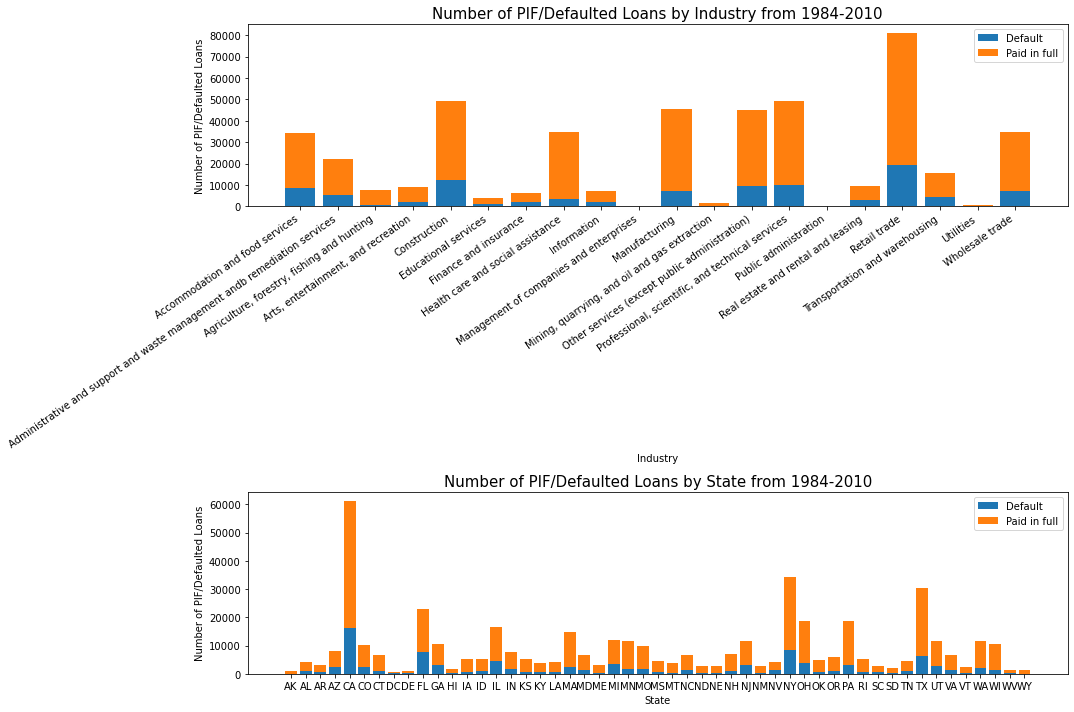

In [37]:
fig3 = plt.figure(figsize=(15, 10))

ax1a = plt.subplot(2, 1, 1)
ax2a = plt.subplot(2, 1, 2)

# Function for creating stacked bar charts grouped by desired column
# df = original data frame, col = x-axis grouping, stack_col = column to show stacked values
# Essentially acts as a stacked histogram when stack_col is a flag variable
def stacked_setup(df, col, axes, stack_col='def_flag'):
    data = df.groupby([col, stack_col])[col].count().unstack(stack_col)
    data.fillna(0)

    axes.bar(data.index, data[1], label='Default')
    axes.bar(data.index, data[0], bottom=data[1], label='Paid in full')


# Number of Paid in full and defaulted loans by industry
stacked_setup(df=df, col='industry_label', axes=ax1a)
ax1a.set_xticklabels(df.groupby(['industry_label', 'def_flag'])['industry_label'].count().unstack('def_flag').index,
                     rotation=35, horizontalalignment='right', fontsize=10)

ax1a.set_title('Number of PIF/Defaulted Loans by Industry from 1984-2010', fontsize=15)
ax1a.set_xlabel('Industry')
ax1a.set_ylabel('Number of PIF/Defaulted Loans')
ax1a.legend()

# Number of Paid in full and defaulted loans by State
stacked_setup(df=df, col='state', axes=ax2a)

ax2a.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax2a.set_xlabel('State')
ax2a.set_ylabel('Number of PIF/Defaulted Loans')
ax2a.legend()

plt.tight_layout()
plt.show()

### 2.6. Check Default percentage by Industry

In [31]:
def_ind = df.groupby(['industry_label', 'def_flag'])['industry_label'].count().unstack('def_flag')
def_ind['Def_Percent'] = def_ind[1]/(def_ind[1] + def_ind[0])
def_ind

def_flag,0,1,Def_Percent
industry_label,,,
Accommodation and food services,25701,8565,0.249956
Administrative and support and waste management andb remediation services,16537,5475,0.248728
"Agriculture, forestry, fishing and hunting",6960,669,0.087692
"Arts, entertainment, and recreation",7311,1953,0.210816
Construction,37053,12185,0.247471
Educational services,2918,1087,0.271411
Finance and insurance,4232,2104,0.332071
Health care and social assistance,30878,3627,0.105115
Information,5509,1843,0.250680


### 2.7. Check Default percentage by State

In [32]:
def_state = df.groupby(['state', 'def_flag'])['state'].count().unstack('def_flag')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state

def_flag,0,1,Def_Percent
state,,,
AK,1006,97,0.087942
AL,3299,816,0.198299
AR,2519,534,0.174910
AZ,5440,2504,0.315206
CA,45091,16296,0.265463
CO,7866,2381,0.232361
CT,5503,1074,0.163296
DC,592,158,0.210667
DE,873,249,0.221925


### 2.8. Paid in full and Defaulted loans by DisbursementFY

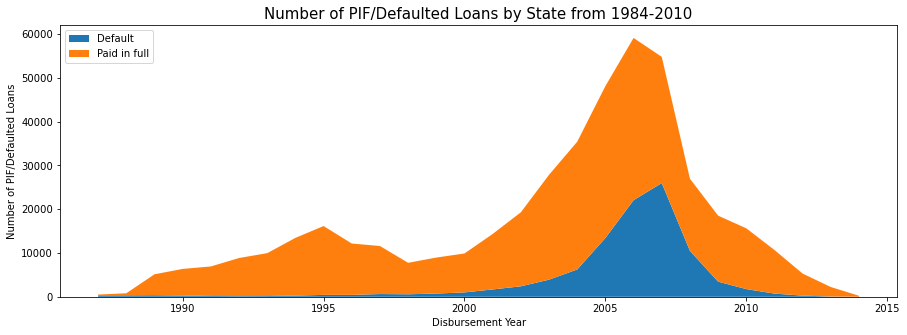

In [33]:
# Decided to use a stacked area chart here since it's time series data
fig4, ax4 = plt.subplots(figsize=(15, 5))

stack_data = df.groupby(['disbursement_year', 'def_flag'])['disbursement_year'].count().unstack('def_flag')
x = stack_data.index
y = [stack_data[1], stack_data[0]]

ax4.stackplot(x, y, labels=['Default', 'Paid in full'])
ax4.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax4.set_xlabel('Disbursement Year')
ax4.set_ylabel('Number of PIF/Defaulted Loans')
ax4.legend(loc='upper left')

plt.show()

### 2.9. Paid in full and defaulted loans backed by Real Estate

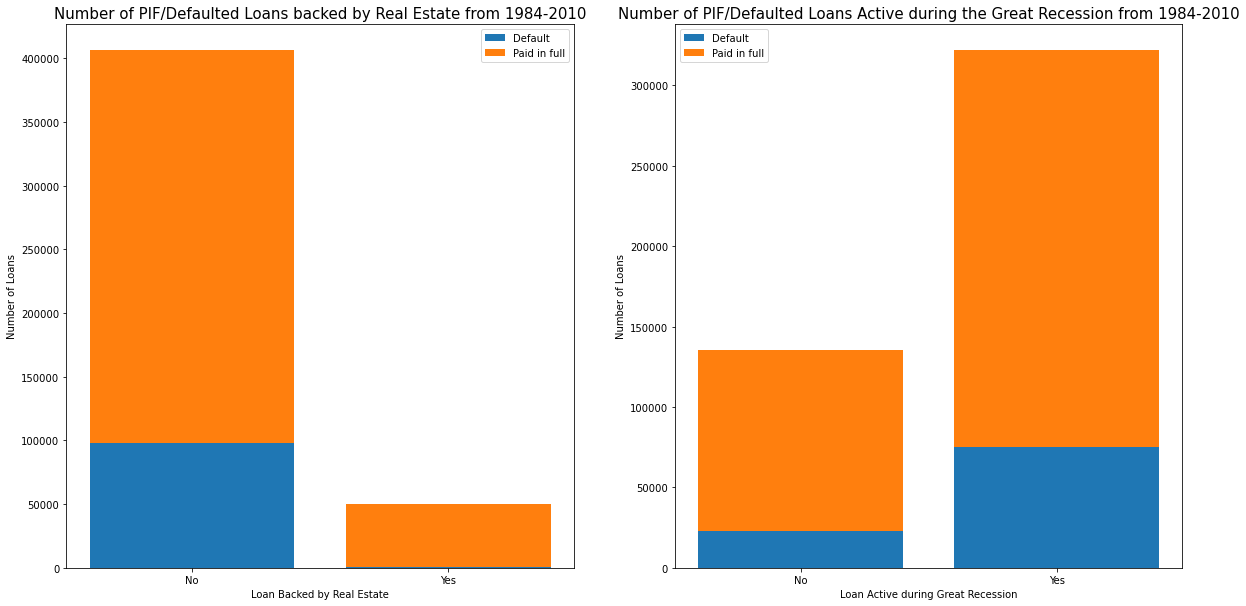

In [38]:
fig5 = plt.figure(figsize=(20, 10))

ax1b = fig5.add_subplot(1, 2, 1)
ax2b = fig5.add_subplot(1, 2, 2)

stacked_setup(df=df, col='real_estate_flag', axes=ax1b)
ax1b.set_xticks(df.groupby(['real_estate_flag', 'def_flag'])['real_estate_flag'].count().unstack('def_flag').index)
ax1b.set_xticklabels(labels=['No', 'Yes'])

ax1b.set_title('Number of PIF/Defaulted Loans backed by Real Estate from 1984-2010', fontsize=15)
ax1b.set_xlabel('Loan Backed by Real Estate')
ax1b.set_ylabel('Number of Loans')
ax1b.legend()

# Paid in full and defaulted loans active during the Great Recession
stacked_setup(df=df, col='recession_flag', axes=ax2b)
ax2b.set_xticks(df.groupby(['recession_flag', 'def_flag'])['recession_flag'].count().unstack('def_flag').index)
ax2b.set_xticklabels(labels=['No', 'Yes'])

ax2b.set_title('Number of PIF/Defaulted Loans Active during the Great Recession from 1984-2010', fontsize=15)
ax2b.set_xlabel('Loan Active during Great Recession')
ax2b.set_ylabel('Number of Loans')
ax2b.legend()

plt.show()

### 2.10. Check Default percentage for loans backed by Real Estate

In [35]:
def_re = df.groupby(['real_estate_flag', 'def_flag'])['real_estate_flag'].count().unstack('def_flag')
def_re['Def_Percent'] = def_re[1]/(def_re[1] + def_re[0])
def_re

def_flag,0,1,Def_Percent
real_estate_flag,,,
0,308837,97690,0.240304
1,49721,692,0.013727


### 2.11. Check Default percentage for loans active during the Great Recession

In [36]:
def_gr = df.groupby(['recession_flag', 'def_flag'])['recession_flag'].count().unstack('def_flag')
def_gr['Def_Percent'] = def_gr[1]/(def_gr[1] + def_gr[0])
def_gr

def_flag,0,1,Def_Percent
recession_flag,,,
0,111973,23134,0.171227
1,246585,75248,0.233811
